<a href="https://colab.research.google.com/github/panicoro/FS-process-image/blob/master/Entrega_Pr%C3%A1ctica_2_Pablo_Rosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 2: Redes neuronales para clasificación de imágenes



En esta práctica, implementaremos redes neuronales para clasificar dígitos manuscritos sin necesidad de extracción manual de características. Utilizaremos el dataset MNIST, que contiene imágenes de dígitos de 28x28 píxeles.



Para empezar, importamos todas las bibliotecas que necesitaremos:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [8, 6]

Luego, cargamos el dataset MNIST y visualizamos algunos ejemplos del conjunto de entrenamiento:

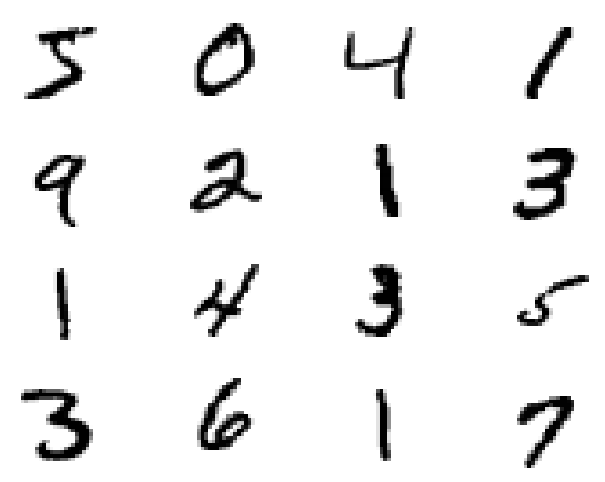

In [2]:
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

plt.figure()
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(train_dataset.data[i], cmap=plt.get_cmap("gray_r"))
    plt.axis('off')

# Red Neuronal Multicapa

En primer luegar, implementaremos una red neuronal multicapa (`MultiLayerNN`) para que pueda clasificar imágenes de 28x28 píxeles en 10 categorías diferentes.

## Arquitectura de la red
* La red contará con dos capas ocultas, cada una con 512 neuronas, y aplicaremos una función de activación ReLU después de cada capa oculta para introducir no linealidad.
* La capa de salida tendrá 10 neuronas, lo que corresponde a las 10 posibles categorías (dígitos del 0 al 9) que el modelo debe predecir.

## Transformación de los datos de entrada
Antes de procesar las imágenes, es necesario convertirlas de una matriz de 28x28 píxeles a un vector de 784 componentes. Esto se logra utilizando la función `view` de los tensores de PyTorch.

## Herramientas de PyTorch:
Algunas clases y funciones de PyTorch que nos serán útiles para implementar el modelo son:
* `nn.Linear`: implementa una capa totalmente conectada. Debemos especificar el número de entradas y salidas de la capa.
* `F.relu`: implementa la función de activación ReLU, que se aplica después de las capas ocultas (la podemos aplicar directamente dentro del método `forward` de la red).

## Entrenamiento del modelo
* **Optimizador**: utilizaremos el método de Gradiente Descendente Estocástico por mini-batches (`optim.SGD`) para ajustar los pesos de la red durante el entrenamiento.
* **Función de pérdida**: la función de pérdida será la Entropía Cruzada (`nn.CrossEntropyLoss`), adecuada para problemas de clasificación multiclase, como la clasificación de dígitos manuscritos.

Comenzamos implementando la red neuronal multicapa:

In [3]:
class MultiLayerNN(torch.nn.Module):
    """
    Red neuronal multicapa (MultiLayerNN)
    """
    def __init__(self):
        super().__init__()
        # Primera capa oculta
        self.fc1 = nn.Linear(784,512)
        # Segunda capa oculta
        self.fc2 = nn.Linear(512,512)
        # Capa de salida
        self.fc3 = nn.Linear(512,10)

    def forward(self, x):
        # Transformar la entrada en un vector para las capas totalmente
        # conectadas
        x = x.view(-1, 784)
        # Aplicar la primera capa oculta seguida de ReLU
        x = self.fc1(x)
        x = F.relu(x)
        # Aplicar la segunda capa oculta seguida de ReLU
        x = self.fc2(x)
        x = F.relu(x)
        # Aplicar la capa de salida
        x = self.fc3(x)
        return x

Ahora, implementamos el proceso de entrenamiento de la red:

In [4]:
# Configuración del dispositivo (GPU si está disponible, de lo contrario CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Construcción del modelo y envío al dispositivo
model1 = MultiLayerNN()
model1.to(device)

# Creación de dataLoaders para manejar los batches de entrenamiento y prueba
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                         shuffle=False)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.01)

# Lista para guardar los valores de pérdida durante el entrenamiento
train_loss = []

# Épocas de entrenamiento
num_epochs = 10

# Establecer el modelo en modo entrenamiento
model1.train()

# Bucle de entrenamiento
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Mover los datos a la GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Limpiar los gradientes
        optimizer.zero_grad()

        # Pasada forward
        outputs = model1(inputs)

        # Cálcular la pérdida
        loss = criterion(outputs, labels)

        # Pasada backward
        loss.backward()

        # Actualizar los pesos
        optimizer.step()

        # Guardar el valor de pérdida
        train_loss.append(loss.item())

    print(f"Época {epoch + 1}/{num_epochs}, Pérdida: {loss.item():.4f}")

Época 1/10, Pérdida: 0.7053
Época 2/10, Pérdida: 0.2942
Época 3/10, Pérdida: 0.2709
Época 4/10, Pérdida: 0.2299
Época 5/10, Pérdida: 0.2887
Época 6/10, Pérdida: 0.1276
Época 7/10, Pérdida: 0.0669
Época 8/10, Pérdida: 0.1980
Época 9/10, Pérdida: 0.1326
Época 10/10, Pérdida: 0.3045


Guardamos el modelo para poder reutilizarlo cuando queramos:

In [5]:
torch.save(model1.state_dict(), "./multinn.pth")

Visualizamos los valores de la función de pérdida durante el entrenamiento:

Text(0.5, 1.0, 'Pérdida durante el entrenamiento (MultiLayerNN)')

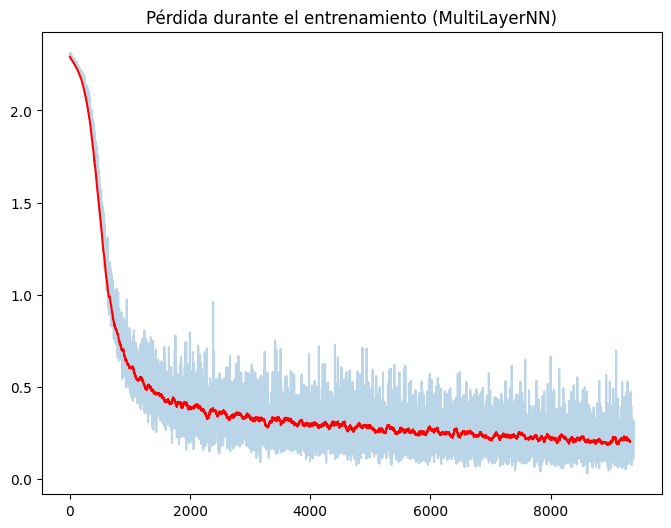

In [6]:
train_loss = np.array(train_loss)
N = 60
run_avg_train_loss = np.convolve(train_loss, np.ones((N,))/N, mode="valid")

plt.figure()
plt.plot(train_loss, alpha = 0.3) # original
plt.plot(run_avg_train_loss, color="red")   # versión suavizada
plt.title("Pérdida durante el entrenamiento (MultiLayerNN)")

Definimos una función para evaluar el modelo entrenado en el conjunto de prueba:

In [7]:
def evaluate_accuracy(model, test_dataset, device="cpu"):
    """
    Calcula la accuracy general y por dígito en el conjunto de prueba.
    """
    model.to(device)

    # Establecer el modelo en modo evaluación
    model.eval()

    correct_per_class = torch.zeros(10)  # Conteo correcto por dígito
    total_per_class = torch.zeros(10)    # Total de ejemplos por dígito
    total_correct = 0
    total_samples = 0

    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    with torch.no_grad():  # No necesitamos gradientes durante la evaluación
        for images, labels in test_loader:
            # Mover los datos a la GPU
            images, labels = images.to(device), labels.to(device)

            # Pasada forward
            outputs = model(images)

            # Obtener las predicciones
            _, predicted = torch.max(outputs, 1)

            # Actualizar el conteo de predicciones correctas y totales
            # por dígito
            for i in range(10):
                correct_per_class[i] += (
                    predicted[labels == i] == i).sum().item()
                total_per_class[i] += (labels == i).sum().item()

            # Actualizar el conteo de predicciones correctas y totales en
            # general
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Calcular la accuracy general
    overall_accuracy = total_correct / total_samples

    # Calcular la accuracy por dígito
    accuracy_per_digit = correct_per_class / total_per_class

    return overall_accuracy, accuracy_per_digit.tolist()

Cargamos el modelo entrenado y lo evaluamos en conjunto de prueba:

In [8]:
# Cargar el modelo entrenado (no es necesario si se encuentra en memoria)
# model1.load_state_dict(torch.load("./multinn.pth", weights_only=True))
# model1.to(device)

# Evaluar el modelo entrenado en el conjunto de prueba
overall_accuracy, accuracy_per_digit = evaluate_accuracy(model1,
                                                         test_dataset,
                                                         device)

print("Resultados MultiLayerNN:\n")

# Mostrar la accuracy general
print(f"Accuracy General: {overall_accuracy:.4f}")
print()

# Mostrar la accuracy por dígito
for i, acc in enumerate(accuracy_per_digit):
    print(f"Accuracy para el dígito {i}: {acc:.4f}")

Resultados MultiLayerNN:

Accuracy General: 0.9416

Accuracy para el dígito 0: 0.9827
Accuracy para el dígito 1: 0.9797
Accuracy para el dígito 2: 0.9331
Accuracy para el dígito 3: 0.9396
Accuracy para el dígito 4: 0.9521
Accuracy para el dígito 5: 0.9114
Accuracy para el dígito 6: 0.9582
Accuracy para el dígito 7: 0.9377
Accuracy para el dígito 8: 0.9045
Accuracy para el dígito 9: 0.9098


# Red Neuronal Convolucional

Ahora probaremos resolver el problema de clasificación utilizando una red neuronal convolucional (`CNN`).

## Arquitectura de la red
La arquitectura de la red está compuesta por las siguientes capas:

* Capa convolucional 1: 6 filtros de 5x5 con stride de 1 y padding de 2.
* Función de activación ReLU.
* Max pooling 1: filtro de 2x2 con stride de 2 y sin padding.
* Capa convolucional 2: 16 filtros de 5x5 con stride de 1 y sin padding.
* Función de activación ReLU.
* Max pooling 2: filtro de 2x2 con stride de 2 y sin padding.
* Capa totalmente conectada 1: 120 neuronas.
* Función de activación ReLU.
* Capa totalmente conectada 2: 84 neuronas.
* Función de activación ReLU.
* Capa de salida: 10 neuronas.

## Herramientas de PyTorch:
Algunas clases y funciones de PyTorch que nos serán útiles para implementar el modelo son:
* `nn.Conv2D`: una capa convolucional 2D. Es necesario especificar el número de canales de entrada, el número de filtros, el tamaño del kernel, el stride y el padding.
* `nn.MaxPool2d`: implementa una capa de max pooling 2D. Se especifica el tamaño del filtro de pooling y el stride.
* `nn.Linear`: implementa una capa totalmente conectada. Debemos especificar el número de entradas y salidas de la capa.
* `F.relu`: implementa la función de activación ReLU, que se aplica después de las capas de convolución y totalmente conectadas (la podemos aplicar directamente dentro del método `forward` de la red).

## Entrenamiento del modelo
* **Optimizador**: utilizaremos el método de Gradiente Descendente Estocástico por mini-batches (`optim.SGD`) para ajustar los pesos de la red durante el entrenamiento.
* **Función de pérdida**: la función de pérdida será la Entropía Cruzada (`nn.CrossEntropyLoss`), adecuada para problemas de clasificación multiclase, como la clasificación de dígitos manuscritos.

## Salida de las capas convolucionales:
Para calcular el tamaño de salida de las capas convolucionales, utilizaremos la siguiente fórmula:

$$O = \frac{(W - F + 2P)}{S} + 1$$

Donde:
* F: tamaño del filtro.
* W: tamaño de la entrada.
* P: padding aplicado.
* S: stride utilizado.


Implementamos la red neuronal convolucional:

In [9]:
class CNN(nn.Module):
    """
    Red neuronal convolucional (CNN)
    """
    def __init__(self):
        super().__init__()
        # Primera capa convolucional + Max pooling
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,
                               kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Segunda capa convolucional + Max pooling
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,
                               kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Capas totalmente conectadas 1 y 2
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        # Capa de salida
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Aplicar la primera capa convolucional seguida de ReLU y Max Pooling
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        # Aplicar la segunda capa convolucional seguida de ReLU y Max Pooling
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        # Transformar la entrada en un vector para las capas totalmente
        # conectadas
        x = x.view(-1, 16 * 5 * 5)
        # Aplicar la primera capa totalmente conectada seguida de ReLU
        x = self.fc1(x)
        x = torch.relu(x)
        # Aplicar la segunda capa totalmente conectada seguida de ReLU
        x = self.fc2(x)
        x = torch.relu(x)
        # Aplicar la capa de salida
        x = self.fc3(x)
        return x

Y el proceso de entrenamiento:

In [10]:
# Configuración del dispositivo (GPU si está disponible, de lo contrario CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Construcción del modelo y envío al dispositivo
model2 = CNN()
model2.to(device)

# Creación de dataLoaders para manejar los batches de entrenamiento y prueba
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                         shuffle=False)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.01)

# Lista para guardar los valores de pérdida durante el entrenamiento
train_loss = []

# Épocas de entrenamiento
num_epochs = 10

# Establecer el modelo en modo entrenamiento
model2.train()

# Bucle de entrenamiento
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Mover los datos a la GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Limpiar los gradientes
        optimizer.zero_grad()

        # Pasada forward
        outputs = model2(inputs)

        # Cálcular la pérdida
        loss = criterion(outputs, labels)

        # Pasada backward
        loss.backward()

        # Actualizar los pesos
        optimizer.step()

        # Guardar el valor de pérdida
        train_loss.append(loss.item())

    print(f"Época {epoch + 1}/{num_epochs}, Pérdida: {loss.item():.4f}")

Época 1/10, Pérdida: 0.2880
Época 2/10, Pérdida: 0.2026
Época 3/10, Pérdida: 0.1403
Época 4/10, Pérdida: 0.0941
Época 5/10, Pérdida: 0.0660
Época 6/10, Pérdida: 0.0623
Época 7/10, Pérdida: 0.0323
Época 8/10, Pérdida: 0.0338
Época 9/10, Pérdida: 0.0073
Época 10/10, Pérdida: 0.0484


Guardamos el modelo para poder reutilizarlo cuando queramos:

In [11]:
torch.save(model2.state_dict(), "./cnn.pth")

Visualizamos los valores de la función de pérdida durante el entrenamiento:

Text(0.5, 1.0, 'Pérdida durante el entrenamiento (CNN)')

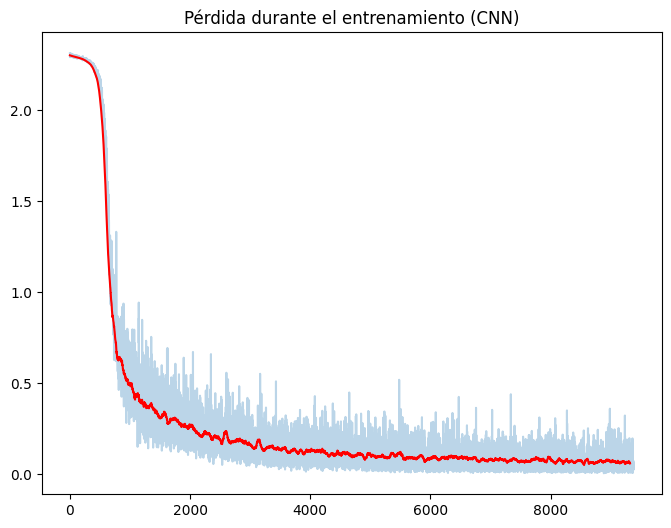

In [12]:
train_loss = np.array(train_loss)
N = 60
run_avg_train_loss = np.convolve(train_loss, np.ones((N,))/N, mode="valid")

plt.figure()
plt.plot(train_loss, alpha = 0.3) # original
plt.plot(run_avg_train_loss, color="red")   # versión suavizada
plt.title("Pérdida durante el entrenamiento (CNN)")

Cargamos el modelo entrenado y lo evaluamos en conjunto de prueba:

In [13]:
# Cargar el modelo entrenado (no es necesario si se encuentra en memoria)
# model2 = CNN()
# model2.load_state_dict(torch.load("./cnn.pth"))
# model2.to(device)

# Evaluar el modelo entrenado en el conjunto de prueba
overall_accuracy, accuracy_per_digit = evaluate_accuracy(model2, test_dataset,
                                                         device)

print("Resultados CNN:\n")

# Mostrar la accuracy general
print(f"Accuracy General: {overall_accuracy:.4f}")
print()

# Mostrar la accuracy por dígito
for i, acc in enumerate(accuracy_per_digit):
    print(f"Accuracy para el dígito {i}: {acc:.4f}")

Resultados CNN:

Accuracy General: 0.9805

Accuracy para el dígito 0: 0.9918
Accuracy para el dígito 1: 0.9921
Accuracy para el dígito 2: 0.9913
Accuracy para el dígito 3: 0.9832
Accuracy para el dígito 4: 0.9776
Accuracy para el dígito 5: 0.9753
Accuracy para el dígito 6: 0.9739
Accuracy para el dígito 7: 0.9757
Accuracy para el dígito 8: 0.9713
Accuracy para el dígito 9: 0.9703


# Entregable

1. Completar el código para la red neuronal multicapa (MultiLayerNN) y la red neuronal convolucional (CNN).
2. Analizar los resultados obtenidos en el conjunto de prueba para ambas redes.

(Opcional):
3. Calcular la cantidad total de parámetros en cada red neuronal y comparar estos valores.
4. Para la red convolucional, calcular y documentar el tamaño de las entradas y salidas de cada capa convolucional, así como el número de feature maps generados en cada capa.
